In [1]:
experiment = "VK008"

In [2]:
data_directory = "/data/nijhawanlab/amplicons/" + experiment + "/"
R1_file = data_directory + experiment + "_R1_001.fastq.gz"
R2_file = data_directory + experiment + "_R2_001.fastq.gz"
primer_file = data_directory + "primers.txt"
samples_file = data_directory + experiment + "_samples.tsv"

In [3]:
from Bio import Seq, SeqIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import csv
import itertools
import re
import colored
import statistics

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
primer_name_regex = re.compile(r"(oVK)(\d{1,3})")

In [5]:
def pad_primer(s):
    m = primer_name_regex.match(s)
    return m.group(1) + m.group(2).rjust(3, '0')

In [6]:
with open(samples_file, "r") as f:
    csvraw = list(csv.reader(f, delimiter='\t'))
col_headers = [pad_primer(h) for h in csvraw[0][1:] ]
row_headers = [ pad_primer(row[0]) for row in csvraw[1:] ]
data = [row[1:] for row in csvraw[1:]]
sample_list = [s for sublist in data for s in sublist if s != '']
sample_dict = {row_headers[r]:{col_headers[c]:data[r][c] for c in range(len(col_headers))} for r in range(0, len(row_headers))}

In [7]:
samples_table = pd.DataFrame( 
    data = [ [p1, p2, sample_dict[p1][p2]] for p1 in sample_dict for p2 in sample_dict[p1] ],
    columns = ["forward_primer", "reverse_primer", "sample"]
)

In [8]:
samples_table

,forward_primer,reverse_primer,sample
0,oVK025,oVK026,1514
1,oVK025,oVK038,1515
2,oVK025,oVK039,1516
3,oVK025,oVK040,1517
4,oVK025,oVK041,1518
...,...,...,...
91,oVK037,oVK044,289
92,oVK037,oVK045,431
93,oVK037,oVK046,water
94,oVK037,oVK047,


In [9]:
primers = []
with open(primer_file, newline='') as primers_IO:
    primer_reader = csv.DictReader(primers_IO, delimiter='\t', fieldnames=['OriginalSeq','sequence','barcode','direction'])
    for primer in primer_reader:
        primers.append(dict(primer))

In [10]:
basePair = {'A':'T','T':'A','G':'C','C':'G'}
basePairTrans = str.maketrans(basePair)
def rcDNA(seq):
    return seq.translate(basePairTrans) [::-1]
def cDNA(seq):
    return seq.translate(basePairTrans)

In [11]:
def IdPrimers(seq):
    found_primers = {
        'fwd_primer':None,
        'fwd_primer_loc':None, 
        'rc_primer':None, 
        'rc_primer_loc':None, 
        'fwd_direction':None,
        'rc_direction':None
    }
    for p in primers:
        p1 = seq.find(p['sequence'])
        if p1 != -1:
            found_primers['fwd_primer'] = p['OriginalSeq']
            found_primers['fwd_primer_loc'] = p1
            found_primers['fwd_direction'] = p['direction']
        p2 = seq.rfind( rcDNA( p['sequence'] ))
        if p2 != -1:
            found_primers['rc_primer'] = p['OriginalSeq']
            found_primers['rc_primer_loc'] = p2
            found_primers['rc_direction'] = p['direction']
    return found_primers

In [12]:
with gzip.open(R1_file, "rt") as R1:
  with gzip.open(R2_file, "rt") as R2:
    reads1 = SeqIO.parse(R1, "fastq")
    reads2 = SeqIO.parse(R2, "fastq")
    maxReads = 100000
    readNumber = 0
    reads_list_1 = []
    reads_list_2 = []
    for (read1, read2) in zip(reads1, reads2):
      reads_list_1.append(read1)
      reads_list_2.append(read2)
      # print(read1.letter_annotations["phred_quality"])
      # R1_sequence = str(read1.seq)
      # R2_sequence = str(read2.seq)
    
      # R1_primers = IdPrimers(R1_sequence)
      # R2_primers = IdPrimers(R2_sequence)
    
      # full_read = {}
      # full_read.update({'R1_'+k:R1_primers[k] for k in R1_primers})
      # full_read.update({'R2_'+k:R2_primers[k] for k in R2_primers})
      # full_read.update({
      #     'R1_sequence':R1_sequence,
      #     'R2_sequence':R2_sequence
      # })

      # if(not None in full_read.values() ):       
      #     reads_list.append(full_read)
      # print(full_read)
      readNumber += 1
      if readNumber == maxReads:
          break
# print(reads_list_1)
print("Total reads: {}".format(readNumber))

Total reads: 100000


In [13]:
%time reads_table = pd.DataFrame(data={"R1":reads_list_1, "R2":reads_list_2}, columns=["R1", "R2"])

CPU times: user 32.1 s, sys: 24.2 ms, total: 32.1 s
Wall time: 32.2 s


In [14]:
%time reads_table["R1_id"] = reads_table.apply(lambda row: row["R1"].id, axis=1)
%time reads_table["R2_id"] = reads_table.apply(lambda row: row["R2"].id, axis=1)

CPU times: user 3.24 s, sys: 9.88 ms, total: 3.25 s
Wall time: 3.22 s
CPU times: user 3.25 s, sys: 9.89 ms, total: 3.26 s
Wall time: 3.26 s


In [15]:
%time reads_table["R1_qual"] = reads_table.apply(lambda row: row["R1"].letter_annotations["phred_quality"] , axis=1)
%time reads_table["R2_qual"] = reads_table.apply(lambda row: row["R2"].letter_annotations["phred_quality"] , axis=1)

CPU times: user 3.24 s, sys: 9.91 ms, total: 3.25 s
Wall time: 3.25 s
CPU times: user 3.41 s, sys: 16.9 ms, total: 3.42 s
Wall time: 3.44 s


In [16]:
reads_table

,R1,R2,R1_id,R2_id,R1_qual,R2_qual
0,"(G, N, T, G, A, A, C, G, T, G, A, T, A, T, T, ...","(T, T, T, T, A, C, G, A, T, C, C, A, G, A, G, ...",GWNJ-1013:249:GW210815000:1:2101:2790:1063,GWNJ-1013:249:GW210815000:1:2101:2790:1063,"[37, 2, 37, 37, 37, 25, 37, 37, 37, 37, 37, 37...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
1,"(T, N, T, T, G, T, C, A, C, C, C, A, G, A, G, ...","(G, C, T, A, C, C, A, C, C, G, A, T, A, T, T, ...",GWNJ-1013:249:GW210815000:1:2101:6424:1063,GWNJ-1013:249:GW210815000:1:2101:6424:1063,"[37, 2, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
2,"(C, N, A, C, G, T, T, G, T, T, G, C, C, A, T, ...","(T, G, C, C, A, T, A, A, C, C, A, T, G, A, G, ...",GWNJ-1013:249:GW210815000:1:2101:22137:1063,GWNJ-1013:249:GW210815000:1:2101:22137:1063,"[37, 2, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
3,"(T, T, T, T, A, C, G, A, T, C, C, A, G, A, G, ...","(G, C, T, A, C, C, G, A, G, G, A, T, A, T, T, ...",GWNJ-1013:249:GW210815000:1:2101:13883:1110,GWNJ-1013:249:GW210815000:1:2101:13883:1110,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
4,"(C, N, T, C, C, G, G, T, G, A, T, A, T, T, G, ...","(T, T, A, T, G, C, A, C, T, C, C, A, G, A, G, ...",GWNJ-1013:249:GW210815000:1:2101:24876:1110,GWNJ-1013:249:GW210815000:1:2101:24876:1110,"[37, 2, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
...,...,...,...,...,...,...
99995,"(G, C, C, T, C, C, G, G, T, G, A, T, A, T, T, ...","(T, A, T, G, C, A, C, T, C, C, A, G, A, G, G, ...",GWNJ-1013:249:GW210815000:1:2135:24985:17487,GWNJ-1013:249:GW210815000:1:2135:24985:17487,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
99996,"(G, C, T, A, C, T, G, C, T, G, A, T, A, T, T, ...","(T, T, T, T, A, C, G, A, T, C, C, A, G, A, G, ...",GWNJ-1013:249:GW210815000:1:2135:2953:17503,GWNJ-1013:249:GW210815000:1:2135:2953:17503,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...","[37, 37, 37, 37, 25, 37, 37, 37, 37, 37, 37, 3..."
99997,"(T, T, T, T, C, T, C, T, A, C, C, A, G, A, G, ...","(G, C, T, A, C, C, A, C, C, G, A, T, A, T, T, ...",GWNJ-1013:249:GW210815000:1:2135:6587:17503,GWNJ-1013:249:GW210815000:1:2135:6587:17503,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 2...","[25, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."
99998,"(A, T, C, C, A, G, A, G, G, T, T, G, A, T, T, ...","(G, C, T, A, C, C, A, C, C, G, A, T, A, T, T, ...",GWNJ-1013:249:GW210815000:1:2135:8142:17534,GWNJ-1013:249:GW210815000:1:2135:8142:17534,"[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3..."


In [35]:
def SeqDiagnosticPlot(sequences):

    def list_element(l, n, default=None):
      try:
        return l[n]
      except IndexError:
        return default
    
    def getReadCounts(sequences, maxLen):
        read_counts = [0] * maxLen
        for i in range(maxLen):
            count = 0
            for s in sequences:
                if list_element(s, i):
                    count += 1
            read_counts[i] = count
        return read_counts
    
    qual_scores_list = [ s.letter_annotations["phred_quality"] for s in sequences ]
    sequences_list = [ list(s.seq) for s in sequences ] 
    all_lengths_list = [len(l) for l in sequences_list]
    max_length = max(all_lengths_list)
    N_counts_by_position = [ 
        [ list_element(sub_l, i) for sub_l in sequences_list ].count('N') for i in range(max_length) ]
    qual_by_position_list = [ 
        [ list_element(sub_l, i) for sub_l in qual_scores_list ] for i in range(max_length) ]
    qual_by_position_list = [
        [ i for i in sub_l if i] for sub_l in qual_by_position_list ]
    positions = range(1, max_length + 1)
    max_qual_by_position = [max(l) for l in qual_by_position_list]
    min_qual_by_position = [min(l) for l in qual_by_position_list]
    median_qual_by_position = [statistics.median(l) for l in qual_by_position_list]
    read_counts_list = getReadCounts(sequences_list, max_length)
    
    fig, (axis_quality, axis_N, axis_read_count) = plt.subplots(
        3,1,
        sharex='all',
        figsize=(15,7)
    )
    
    min_max_handle = axis_quality.fill_between(
        x=positions, 
        y1=min_qual_by_position, 
        y2=max_qual_by_position, 
        color="lightgrey", 
        label='range')
    median_handle, = axis_quality.step(
        x=positions,
        y=median_qual_by_position, 
        label='median')
    axis_quality.legend(loc='lower center')
    axis_quality.set_xlabel('position')
    axis_quality.set_ylabel('quality')
    axis_quality.yaxis.grid(True)
    axis_quality.spines["bottom"].set_visible(True)
    axis_quality.spines["top"].set_visible(False)
    axis_quality.spines["left"].set_visible(True)
    axis_quality.spines["right"].set_visible(False)
    
    axis_read_count.set_yscale('log')
    axis_read_count.plot(read_counts_list, color='grey')
    axis_read_count.hist(all_lengths_list, range=(0,max_length), bins=25, color='lightblue')
    axis_read_count.set_ylabel('read count')
    axis_read_count.spines["bottom"].set_visible(True)
    axis_read_count.spines["top"].set_visible(False)
    axis_read_count.spines["left"].set_visible(True)
    axis_read_count.spines["right"].set_visible(False)
    
    axis_N.spines["bottom"].set_visible(True)
    axis_N.spines["top"].set_visible(False)
    axis_N.spines["left"].set_visible(True)
    axis_N.spines["right"].set_visible(False)
    axis_N.step(x=positions, y=N_counts_by_position)
    axis_N.set_ylabel('N content')

    return plt.show()

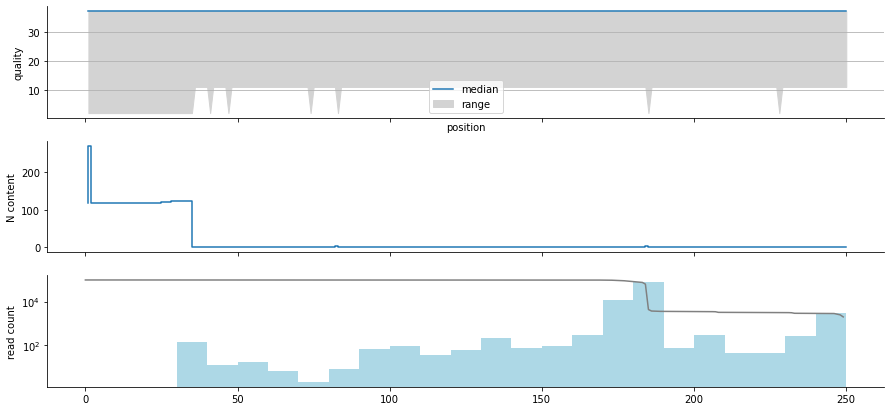

CPU times: user 39.6 s, sys: 62.9 ms, total: 39.7 s
Wall time: 39.8 s


In [36]:
%time SeqDiagnosticPlot(list(reads_table["R1"]))

In [ ]:
%time SeqDiagnosticPlot(list(reads_table["R2"]))

In [ ]:
def MinQualityDistribution(sequences):
    N_reads = len(sequences)
    min_qual_list = [ min(s.letter_annotations["phred_quality"]) for s in list(sequences) ]
    fig, ax = plt.subplots(
        figsize=(15,7)
    )
    ax.hist(min_qual_list, range=(0,40), bins=8)
    ax.set_title('Read Counts by Minimum Qualtiy\nTotal Reads: {}'.format(N_reads))
    
    return plt.show()

In [ ]:
MinQualityDistribution(reads_table["R1"])

In [ ]:
MinQualityDistribution(reads_table["R2"])

In [ ]:
R1 = gzip.open(R1_file, "rt")
R2 = gzip.open(R2_file, "rt")
reads1 = SeqIO.parse(R1, "fastq")
reads2 = SeqIO.parse(R2, "fastq")
maxReads = 500000
readNumber = 0
reads_list = []
for (read1, read2) in zip(reads1, reads2):
    R1_sequence = str(read1.seq)
    R2_sequence = str(read2.seq)
    
    R1_primers = IdPrimers(R1_sequence)
    R2_primers = IdPrimers(R2_sequence)
    
    full_read = {}
    full_read.update({'R1_'+k:R1_primers[k] for k in R1_primers})
    full_read.update({'R2_'+k:R2_primers[k] for k in R2_primers})
    full_read.update({
        'R1_sequence':R1_sequence,
        'R2_sequence':R2_sequence
    })

    if(not None in full_read.values() ):       
        reads_list.append(full_read)
    # print(full_read)
    readNumber += 1
    if readNumber > maxReads:
        break

print("maxReads: {}\nTotal reads: {}".format(maxReads,readNumber-1))
reads_table = pd.DataFrame(reads_list)
        
R1.close()
R2.close()